<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/colorCorrection/tests/CURL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CURL: Neural Curve Layers for Global Image Enhancement

[GitHub](https://github.com/sjmoran/CURL)

## 1. Preparations

Before start, make sure that you choose

Runtime Type = Python 3
Hardware Accelerator = GPU

In [10]:
!nvidia-smi

Thu May 12 08:46:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. linking nextcloud

Connecting to the external NextCloud drive 

In [11]:
# we'll link the dataset from next-cloud
!curl https://raw.githubusercontent.com/luca-arts/seeingtheimperceptible/main/notebooks/database_mod.py -o /content/database_mod.py

from database_mod import *

link_nextcloud()

nextcloud = '/content/database/'

input_folder, output_folder = create_io(database=nextcloud,topic='colorCorrection/CURL',library='CURL')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2480  100  2480    0     0  16644      0 --:--:-- --:--:-- --:--:-- 16756
what's the username for nextcloud? colab
what's the password for user colab? ··········
1
Please enter the username to authenticate with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Username: Please enter the password to authenticate user colab with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Password:  


In [12]:
CURL_direction = '/content/database/colorCorrection/CURL/output'

## 3. clone GIT repo

In [13]:
! git clone https://github.com/sjmoran/CURL

# for CPU compatible code use the command below and comment out the above line
# !git clone https://github.com/deshwalmahesh/CURL---cpu-gpu

# Navigate inside the cloned repo
% cd ./CURL/

 adobe5k_dpe/              log_2022-05-12_08-14-37/   raw_ted.py
'Colab Demo.ipynb'         main.py                    README.md
 CURL_for_RGB_images.zip   metric.py                  requirements.txt
 CURL_large_batch.tar.gz   model.py                   rgb_ted.py
 data.py                   pretrained_models/         runs/
 images/                   __pycache__/               util.py


## Imports

In [37]:
import numpy as np
from PIL import Image
import sys
import torch
import torchvision.transforms.functional as TF
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Imports from the code written by authors inside modules
import model
import util
from util import ImageProcessing

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Might not work without GPU so if you want the cpu verson, clone https://github.com/deshwalmahesh/CURL---cpu-gpu

## Helpers

In [38]:
def resize(image, new_width_height = 1920, convert_RGB = True):
  '''
  Resize and return Given Image
  args:
    path: Image Path, BytesIO or the image 
    new_width_height = Reshaped image's width and height. # If integer is given, it'll keep the aspect ratio as it is by shrinking the Bigger dimension (width or height) to the max of new_width_height  and then shring the smaller dimension accordingly 
    convert_RGB: Whether to Convert the RGBA image to RGB (by default backgroud is white)
  '''
  image = Image.open(image) if isinstance(image, (str, BytesIO)) else image
  w, h = image.size

  fixed_size = new_width_height if isinstance(new_width_height, int) else False

  if fixed_size:
    if h > w:
      fixed_height = fixed_size
      height_percent = (fixed_height / float(h))
      width_size = int((float(w) * float(height_percent)))
      image = image.resize((width_size, fixed_height), Image.NEAREST)

    else:
      fixed_width = fixed_size
      width_percent = (fixed_width / float(w))
      height_size = int((float(h) * float(width_percent)))
      image = image.resize((fixed_width, height_size), Image.NEAREST) # Try Image.ANTIALIAS inplace of Image.NEAREST

  else:
    image = image.resize(new_width_height)

  if image.mode == "RGBA" and convert_RGB:
  
    new = Image.new("RGBA", image.size, "WHITE") # Create a white rgba background
    new.paste(image, (0, 0), image) # Paste the image on the background.
    image = new.convert('RGB')

  return image



def load_image(path, resize_image_size = 1920):
    '''
    Load the image as tensor according to the format authors have used in the code
    '''
    if ("https" in path) or ("http" in path):
      image = Image.open(BytesIO(requests.get(path).content))

    else:
      image = Image.open(path)

    if image.mode != 'RGB':
      image = image.convert('RGB')
    
    if resize:
      image = resize(image, resize_image_size)
               
    return TF.to_tensor(image).to(DEVICE)


## Load pre-trained model


In [39]:
checkpoint_filepath = "./pretrained_models/adobe_dpe/curl_validpsnr_23.073045286204017_validloss_0.0701291635632515_testpsnr_23.584083321292365_testloss_0.061363041400909424_epoch_510_model.pt"

# Build Model
net = model.CURLNet()
checkpoint = torch.load(checkpoint_filepath, map_location=DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()
if DEVICE == 'cuda':
  net.cuda()


def evaluate(img, convert_uint = False):
    """
    Evaluate the model per image instance. Image of Batch size 1. Can be used in API production
    """
    img = load_image(img)

    with torch.no_grad():

        img = img.unsqueeze(0)
        img = torch.clamp(img, 0, 1)

        net_output_img_example , _ = net(img)

        net_output_img_example_numpy = net_output_img_example.squeeze(0).data.cpu().numpy()
        net_output_img_example_numpy = ImageProcessing.swapimdims_3HW_HW3(net_output_img_example_numpy)
        return (net_output_img_example_numpy* 255).astype(np.uint8) if convert_uint else net_output_img_example_numpy



In [42]:
print(len(os.listdir(input_folder)))

10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.


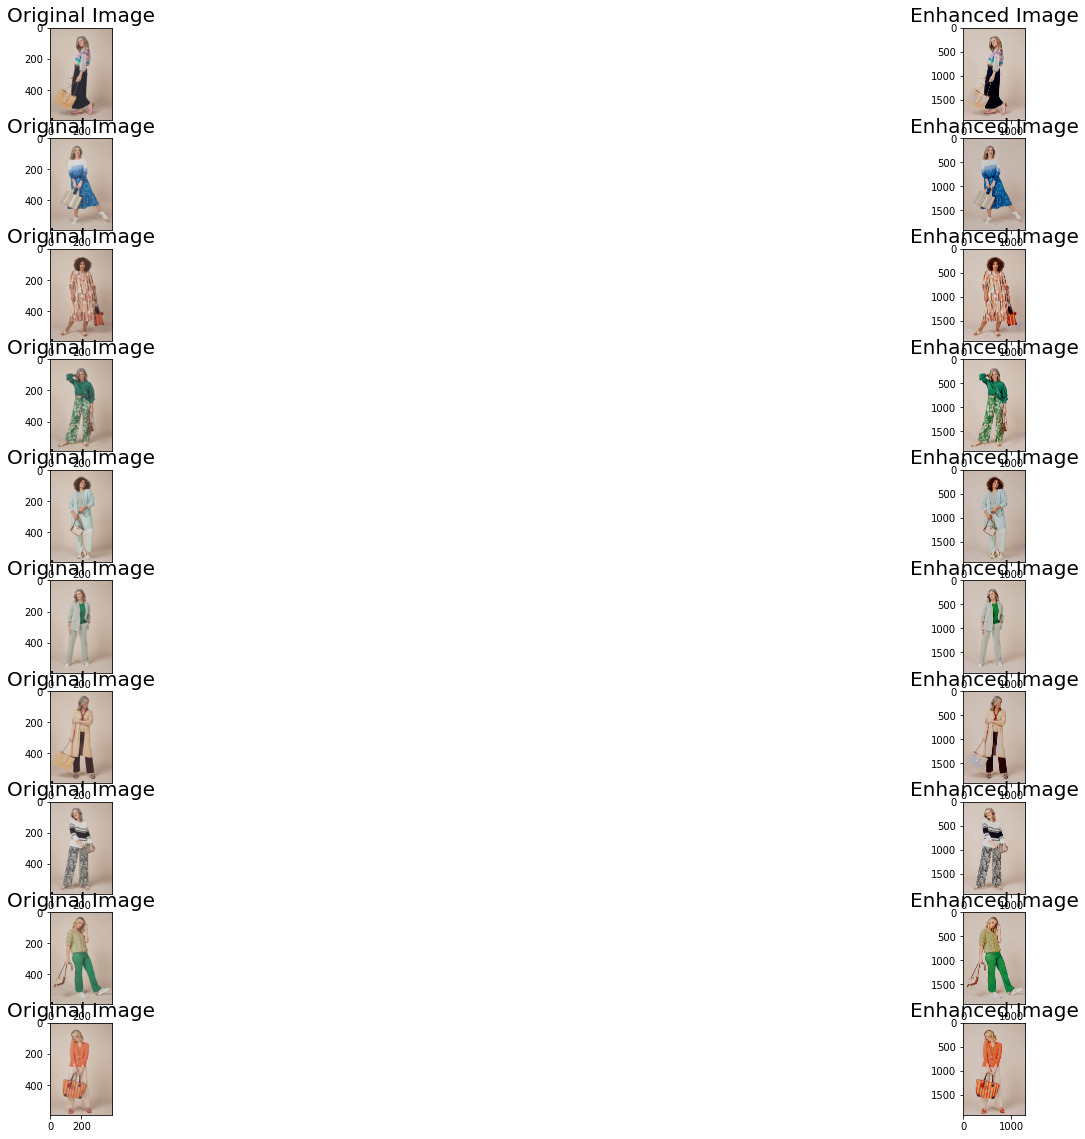

In [43]:
%matplotlib inline
imgs_to_convert = os.listdir(input_folder)

f, ax = plt.subplots(len(imgs_to_convert),2, figsize = (30,20))

for i, _img in enumerate(imgs_to_convert):

  result = evaluate(os.path.join(input_folder,_img), convert_uint = False) # gives you array between 0-1 so if you want an "Image", use 'convert_uint = True', then Image.fromarray(array).save(path)

  ax[i][0].imshow(np.array(Image.open(os.path.join(input_folder,_img)))) # Original image
  ax[i][1].imshow(result) # retouched

  ax[i][0].set_title("Original Image", fontsize=20)
  ax[i][1].set_title("Enhanced Image", fontsize=20)

plt.show()


## 4. Setting up the environment

In [14]:
# installing CURL
%cd {root_path}
!pip install -q -r requirements.txt

/content/CURL


# 5. Inference

In [7]:
replace_text_in_file('main.py','exit()','#exit()')

exit() not found


In [36]:
# inference path
#inf_path = root_path + ''

# python3 main.py
#    --inference_img_dirpath={./adobe5k_dpe/} 
#    --checkpoint_filepath=./pretrained_models/curl_validpsnr_23.073045286204017_validloss_0.0701291635632515_testpsnr_23.584083321292365_testloss_0.061363041400909424_epoch_510_model.pt
# /content/database/colorCorrection/CURL/
!python3 main.py --inference_img_dirpath=./adobe5k_dpe/    --checkpoint_filepath=./pretrained_models/adobe_dpe/curl_validpsnr_23.073045286204017_validloss_0.0701291635632515_testpsnr_23.584083321292365_testloss_0.061363041400909424_epoch_510_model.pt

*** Before running this code ensure you keep the default batch size of 1. The code has not been engineered to support higher batch sizes. See README for more detail. Remove the #exit() statement to use code. ***
2022-05-12 09:47:34,277 INFO ######### Parameters #########
2022-05-12 09:47:34,278 INFO Number of epochs: 100000
2022-05-12 09:47:34,278 INFO Logging directory: ./log_2022-05-12_09-47-34
2022-05-12 09:47:34,278 INFO Dump validation accuracy every: 10
2022-05-12 09:47:34,278 INFO Training image directory: /home/sjm213/adobe5k/adobe5k/
2022-05-12 09:47:34,278 INFO ##############################
2022-05-12 09:47:34,278 INFO Loading Adobe5k dataset ...
2022-05-12 09:47:34,278 INFO a2803-060810_075208_GM6A0020.png
2022-05-12 09:47:34,278 INFO a2803-060810_075208_GM6A0020_input.png
2022-05-12 09:47:34,278 INFO a2803-060810_075208_GM6A0020_VALID_510_30_PSNR_27.756_SSIM_0.982.jpg
2022-05-12 09:47:34,279 INFO Performing inference with images in directory: ./adobe5k_dpe/
2022-05-12 09:4

In [9]:
*for i in os.listdir(input_folder):
  print(i)

SyntaxError: ignored